In [105]:
%matplotlib widget

In [106]:
# IMPORTS
import random
import numpy as np
import pandas as pd

import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import MDS

from deap import algorithms
from deap import base
from deap import creator
from deap import tools

from functools import partial
from ProblemScripts import load_problem_KP

In [107]:
def OneMax_fitness(sol):
    fit = sum(sol)
    return fit

def generate_zero_solution(length):
    return np.zeros(length, dtype=int)

In [108]:
def MutationOnlyEA(NGEN, popsize, tournsize, MUTPB, indpb, starting_solution=None):
    if not hasattr(creator, "OneMax_fitness"):
        creator.create("OneMax_fitness", base.Fitness, weights=(1.0,))
    if not hasattr(creator, "Individual"):
        creator.create("Individual", list, fitness=creator.OneMax_fitness)

    # Define the toolbox
    toolbox = base.Toolbox()
    toolbox.register("attr_bool", random.randint, 0, 1)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=10)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", lambda ind: (sum(ind),))
    toolbox.register("mutate", tools.mutFlipBit, indpb=indpb)
    toolbox.register("select", tools.selTournament, tournsize=tournsize)

    # Create an initial population
    population = toolbox.population(n=popsize)

    # Set starting solution if provided
    if starting_solution is not None:
        for ind in population:
            ind[:] = starting_solution[:]

    # Recording every generation's population
    all_generations = []
    best_solutions = []
    best_fitnesses = []

    # Evaluate the initial population
    fitnesses = list(map(toolbox.evaluate, population))
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit

    # Record initial population and best solution
    all_generations.append([ind[:] for ind in population])
    best_individual = max(population, key=lambda ind: ind.fitness.values)
    best_solutions.append(toolbox.clone(best_individual))
    best_fitnesses.append(best_individual.fitness.values[0])

    # Evolutionary loop
    for gen in range(NGEN):
        # Select the offspring using tournament selection
        offspring = [toolbox.clone(toolbox.select(population, 1)[0]) for _ in range(len(population))]

        # Apply mutation on the offspring
        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Replace the weakest individuals in the population with the offspring regardless of fitness value
        for mutant in offspring:
            weakest_idx = min(range(len(population)), key=lambda idx: population[idx].fitness.values)
            population[weakest_idx] = mutant

        # Record current population and best solution
        all_generations.append([ind[:] for ind in population])
        best_individual = max(population, key=lambda ind: ind.fitness.values)
        best_solutions.append(toolbox.clone(best_individual))
        best_fitnesses.append(best_individual.fitness.values[0])

    return all_generations, best_solutions, best_fitnesses


In [109]:
n_items = 10
ss = generate_zero_solution(n_items)

In [110]:
MutationOnlyEA(NGEN=100, popsize=10, tournsize=3, MUTPB=1, indpb=0.2, starting_solution=ss)

([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
  [[0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
   [0, 0, 1, 0, 0, 0, 0, 0, 0, 1],
   [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
   [0, 0, 1, 0, 0, 1, 0, 1, 0, 0],
   [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
   [1, 0, 1, 0, 0, 0, 0, 1, 0, 1],
   [0, 0, 1, 1, 0, 1, 0, 0, 0, 0],
   [0, 1, 0, 0, 1, 0, 1, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
  [[1, 0, 0, 0, 1, 1, 0, 0, 0, 1],
   [1, 0, 1, 0, 1, 0, 0, 1, 0, 1],
   [0, 0, 1, 1, 1, 0, 0, 0, 1, 0],
   [0, 0, 1, 1, 0, 1, 0, 0, 0, 1],
   [0, 1, 0, 1, 1, 0, 1, 0, 0, 0],
   [1, 1, 1, 0, 0, 0, 1, 1, 0, 1],
   [1, 0, 1, 0, 0, 0, 0, 1, 0, 1],
   [1, 0, 1, 0, 0, 0, 0, 1, 1, 0],
   [0, 1, 0, 0, 1,

In [111]:
all_generations, best_solutions, best_fitnesses = MutationOnlyEA(NGEN=100, popsize=10, tournsize=3, MUTPB=1, indpb=0.2, starting_solution=ss)

In [112]:
def extract_trajectory_data(best_solutions, best_fitnesses):
    # Extract unique solutions and their corresponding fitness values
    unique_solutions = []
    unique_fitnesses = []
    solution_iterations = []
    seen_solutions = {}

    for solution, fitness in zip(best_solutions, best_fitnesses):
        # Convert solution to a tuple to make it hashable
        solution_tuple = tuple(solution)
        if solution_tuple not in seen_solutions:
            seen_solutions[solution_tuple] = 1
            unique_solutions.append(solution)
            unique_fitnesses.append(fitness)
        else:
            seen_solutions[solution_tuple] += 1

    # Create a list of iteration counts for each unique solution
    for solution in unique_solutions:
        solution_tuple = tuple(solution)
        solution_iterations.append(seen_solutions[solution_tuple])

    return unique_solutions, unique_fitnesses, solution_iterations

In [113]:
unique_solutions, unique_fitnesses, solution_iterations = extract_trajectory_data(best_solutions, best_fitnesses)
print(unique_solutions)
print(unique_fitnesses)
print(solution_iterations)

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 1, 1, 0, 0, 0, 1, 0, 0], [1, 1, 1, 0, 0, 0, 1, 1, 1, 1], [1, 1, 1, 0, 1, 0, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 0, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
[0.0, 4.0, 7.0, 8.0, 9.0, 10.0]
[1, 1, 2, 1, 3, 93]


In [114]:
def extract_transitions(unique_solutions):
    # Extract transitions between solutions over generations
    transitions = []

    for i in range(1, len(unique_solutions)):
        prev_solution = tuple(unique_solutions[i - 1])
        current_solution = tuple(unique_solutions[i])
        transitions.append((prev_solution, current_solution))

    return transitions

In [115]:
transitions = extract_transitions(unique_solutions)

In [116]:
print(len(best_solutions))
print(len(transitions))

101
5


In [117]:
def run_multiple_ea_runs(num_runs, NGEN, popsize, tournsize, MUTPB, indpb, starting_solution=None):
    all_run_trajectories = []
    for run in range(num_runs):
        _, best_solutions, best_fitnesses = MutationOnlyEA(NGEN, popsize, tournsize, MUTPB, indpb, starting_solution)
        unique_solutions, unique_fitnesses, solution_iterations = extract_trajectory_data(best_solutions, best_fitnesses)
        transitions = extract_transitions(unique_solutions)
        all_run_trajectories.append((unique_solutions, unique_fitnesses, solution_iterations, transitions))
    return all_run_trajectories

In [118]:
all_run_trajectories = run_multiple_ea_runs(num_runs=2, NGEN=100, popsize=10, tournsize=3, MUTPB=1, indpb=0.2, starting_solution=ss)

In [119]:
def plot_trajectory_network(all_run_trajectories, show_labels=False, start_node_color='yellow', end_node_color='grey', best_node_color='red'):
    # Close any existing plots
    plt.close('all')
    
    G = nx.DiGraph()

    # Add nodes and edges for each run
    node_mapping = {}  # To ensure unique solutions map to the same node
    start_nodes = []
    end_nodes = []
    overall_best_node = None
    overall_best_fitness = max(max(best_fitnesses) for _, best_fitnesses, _, _ in all_run_trajectories)

    for run_idx, (unique_solutions, unique_fitnesses, _, transitions) in enumerate(all_run_trajectories):
        for i, solution in enumerate(unique_solutions):
            solution_tuple = tuple(solution)
            if solution_tuple not in node_mapping:
                node_label = f"Solution {len(node_mapping) + 1}"
                node_mapping[solution_tuple] = node_label
                G.add_node(node_label, solution=solution, fitness=unique_fitnesses[i], run_idx=run_idx, step=i)
            else:
                node_label = node_mapping[solution_tuple]

            # Set start and end nodes for coloring later
            if i == 0:
                start_nodes.append(node_label)
            if i == len(unique_solutions) - 1:
                end_nodes.append(node_label)

            # Track the overall best node for coloring
            if unique_fitnesses[i] == overall_best_fitness:
                overall_best_node = node_label

        # Add edges based on transitions
        for prev_solution, current_solution in transitions:
            if prev_solution in node_mapping and current_solution in node_mapping:
                G.add_edge(node_mapping[prev_solution], node_mapping[current_solution])

    # Draw the graph
    pos = nx.kamada_kawai_layout(G)
    node_labels = {node: f"{data['fitness']}" for node, data in G.nodes(data=True)}
    node_colors = []
    for node in G.nodes():
        if node == overall_best_node:
            node_colors.append(best_node_color)
        elif node in start_nodes:
            node_colors.append(start_node_color)
        elif node in end_nodes:
            node_colors.append(end_node_color)
        else:
            node_colors.append("skyblue")

    nx.draw(G, pos, with_labels=show_labels, node_size=200, node_color=node_colors, font_size=8, font_weight="bold")
    if show_labels:
        nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)
    # plt.title("Trajectory Network of Multiple EA Runs")
    plt.show()

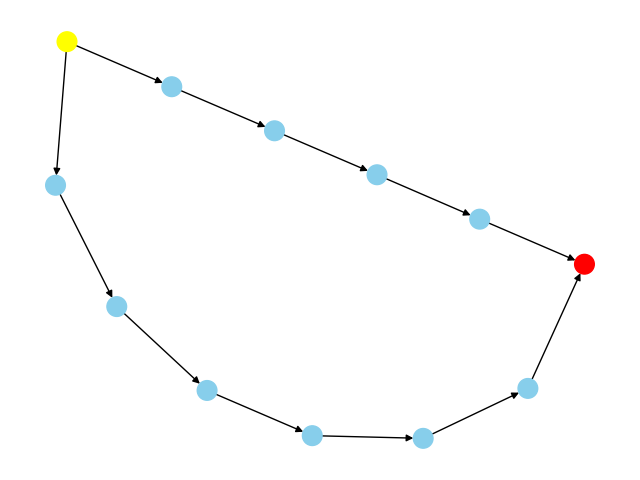

In [120]:
plot_trajectory_network(all_run_trajectories)

In [121]:
def plot_trajectory_network_nodeSizeIncoming(all_run_trajectories, show_labels=False, start_node_color='yellow', end_node_color='grey', best_node_color='red'):
    import networkx as nx
    import matplotlib.pyplot as plt
    # Close any existing plots
    plt.close('all')

    G = nx.DiGraph()

    # Add nodes and edges for each run
    node_mapping = {}  # To ensure unique solutions map to the same node
    start_nodes = []
    end_nodes = []
    overall_best_node = None
    overall_best_fitness = max(max(best_fitnesses) for _, best_fitnesses, _, _ in all_run_trajectories)

    for run_idx, (unique_solutions, unique_fitnesses, _, transitions) in enumerate(all_run_trajectories):
        for i, solution in enumerate(unique_solutions):
            solution_tuple = tuple(solution)
            if solution_tuple not in node_mapping:
                node_label = f"Solution {len(node_mapping) + 1}"
                node_mapping[solution_tuple] = node_label
                G.add_node(node_label, solution=solution, fitness=unique_fitnesses[i], run_idx=run_idx, step=i)
            else:
                node_label = node_mapping[solution_tuple]

            # Set start and end nodes for coloring later
            if i == 0:
                start_nodes.append(node_label)
            if i == len(unique_solutions) - 1:
                end_nodes.append(node_label)

            # Track the overall best node for coloring
            if unique_fitnesses[i] == overall_best_fitness:
                overall_best_node = node_label

        # Add edges based on transitions
        for prev_solution, current_solution in transitions:
            if prev_solution in node_mapping and current_solution in node_mapping:
                G.add_edge(node_mapping[prev_solution], node_mapping[current_solution])

    # Draw the graph
    pos = nx.kamada_kawai_layout(G)
    node_labels = {node: f"{data['fitness']}" for node, data in G.nodes(data=True)}
    node_colors = []
    node_sizes = []
    for node in G.nodes():
        if node == overall_best_node:
            node_colors.append(best_node_color)
        elif node in start_nodes:
            node_colors.append(start_node_color)
        elif node in end_nodes:
            node_colors.append(end_node_color)
        else:
            node_colors.append("skyblue")

        # Set node size proportional to the incoming degree (number of incoming edges)
        incoming_degree = G.in_degree(node)
        node_sizes.append(50 + incoming_degree * 200)  # Base size of 300, increase by 200 per incoming edge

    nx.draw(G, pos, with_labels=show_labels, node_size=node_sizes, node_color=node_colors, font_size=8, font_weight="bold")
    if show_labels:
        nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)
    # plt.title("Trajectory Network of Multiple EA Runs")
    plt.show()

    # Print network information
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    run_edges_list = []
    for run_idx, (unique_solutions, _, _, _) in enumerate(all_run_trajectories):
        run_edges = len(unique_solutions) - 1
        run_edges_list.append(run_edges)
        print(f"Run {run_idx + 1}: Number of edges = {run_edges}")
    num_end_nodes = len(set(end_nodes))
    avg_path_length = sum(run_edges_list) / len(run_edges_list) if run_edges_list else 0
    std_dev_path_length = (sum((x - avg_path_length) ** 2 for x in run_edges_list) / len(run_edges_list)) ** 0.5 if run_edges_list else 0

    print(f"Nodes: {num_nodes}")
    print(f"Edges: {num_edges}")
    print(f"Ends: {num_end_nodes}")
    print(f"Avg. path length: {avg_path_length:.2f} (std: {std_dev_path_length:.2f})")

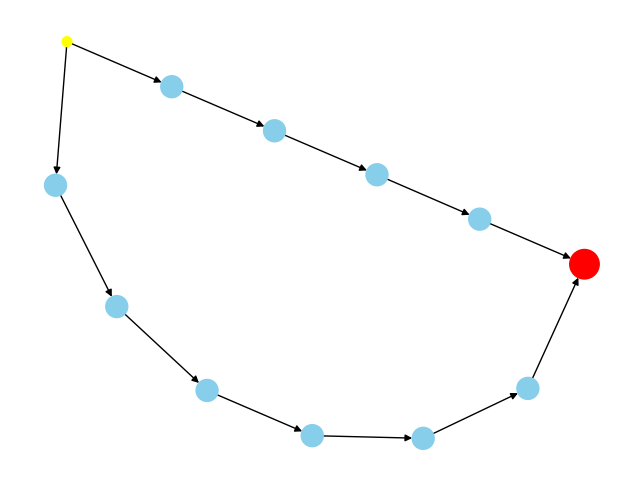

Run 1: Number of edges = 5
Run 2: Number of edges = 7
Nodes: 12
Edges: 12
Ends: 1
Avg. path length: 6.00 (std: 1.00)


In [122]:
plot_trajectory_network_nodeSizeIncoming(all_run_trajectories)

In [124]:
n_items = 10
ss = generate_zero_solution(n_items)
all_run_trajectories = run_multiple_ea_runs(num_runs=10, NGEN=100, popsize=10, tournsize=3, MUTPB=1, indpb=0.2, starting_solution=ss)

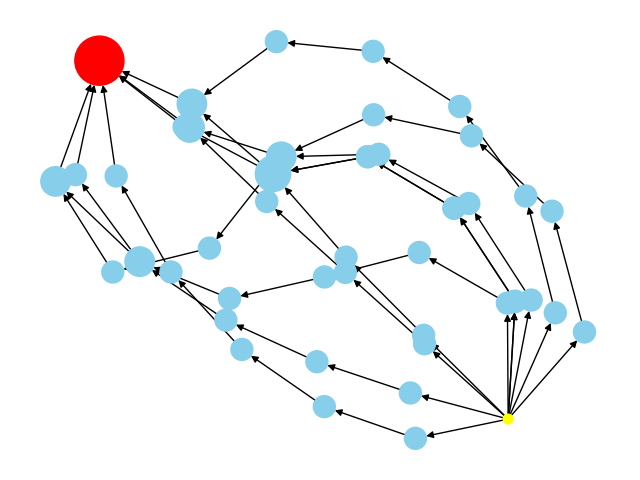

Run 1: Number of edges = 7
Run 2: Number of edges = 7
Run 3: Number of edges = 6
Run 4: Number of edges = 6
Run 5: Number of edges = 8
Run 6: Number of edges = 6
Run 7: Number of edges = 5
Run 8: Number of edges = 5
Run 9: Number of edges = 7
Run 10: Number of edges = 6
Nodes: 47
Edges: 58
Ends: 1
Avg. path length: 6.30 (std: 0.90)


In [125]:
plot_trajectory_network_nodeSizeIncoming(all_run_trajectories)

In [130]:
def plot_trajectory_network_3D(all_run_trajectories, show_labels=False, start_node_color='yellow', end_node_color='grey', best_node_color='red'):
    import networkx as nx
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    import numpy as np

    # Close any existing plots
    plt.close('all')

    G = nx.DiGraph()

    # Add nodes and edges for each run
    node_mapping = {}  # To ensure unique solutions map to the same node
    start_nodes = []
    end_nodes = []
    overall_best_node = None
    overall_best_fitness = max(max(best_fitnesses) for _, best_fitnesses, _, _ in all_run_trajectories)

    for run_idx, (unique_solutions, unique_fitnesses, _, transitions) in enumerate(all_run_trajectories):
        for i, solution in enumerate(unique_solutions):
            solution_tuple = tuple(solution)
            if solution_tuple not in node_mapping:
                node_label = f"Solution {len(node_mapping) + 1}"
                node_mapping[solution_tuple] = node_label
                G.add_node(node_label, solution=solution, fitness=unique_fitnesses[i], run_idx=run_idx, step=i)
            else:
                node_label = node_mapping[solution_tuple]

            # Set start and end nodes for coloring later
            if i == 0:
                start_nodes.append(node_label)
            if i == len(unique_solutions) - 1:
                end_nodes.append(node_label)

            # Track the overall best node for coloring
            if unique_fitnesses[i] == overall_best_fitness:
                overall_best_node = node_label

        # Add edges based on transitions
        for prev_solution, current_solution in transitions:
            if prev_solution in node_mapping and current_solution in node_mapping:
                G.add_edge(node_mapping[prev_solution], node_mapping[current_solution])

    # Prepare data for 3D plotting
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    pos = nx.kamada_kawai_layout(G, dim=3)  # Use spring layout for 3D coordinates
    xs = [pos[node][0] for node in G.nodes()]
    ys = [pos[node][1] for node in G.nodes()]
    zs = [data['fitness'] for node, data in G.nodes(data=True)]

    # Calculate node sizes based on the number of incoming edges (in-degree)
    node_sizes = [50 + G.in_degree(node) * 50 for node in G.nodes()]

    # Node colors
    node_colors = []
    for node in G.nodes():
        if node == overall_best_node:
            node_colors.append(best_node_color)
        elif node in start_nodes:
            node_colors.append(start_node_color)
        elif node in end_nodes:
            node_colors.append(end_node_color)
        else:
            node_colors.append("skyblue")

    ax.scatter(xs, ys, zs, c=node_colors, s=node_sizes, depthshade=True)

    # Draw edges
    for edge in G.edges():
        x = [pos[edge[0]][0], pos[edge[1]][0]]
        y = [pos[edge[0]][1], pos[edge[1]][1]]
        z = [G.nodes[edge[0]]['fitness'], G.nodes[edge[1]]['fitness']]
        ax.plot(x, y, z, c='black', alpha=0.5)

    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Fitness')
    # plt.title("3D Trajectory Network of Multiple EA Runs")
    plt.show()

    # Print requested information
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    run_edges_list = []
    for run_idx, (unique_solutions, _, _, _) in enumerate(all_run_trajectories):
        run_edges = len(unique_solutions) - 1
        run_edges_list.append(run_edges)
        print(f"Run {run_idx + 1}: Number of edges = {run_edges}")
    num_end_nodes = len(set(end_nodes))
    avg_path_length = sum(run_edges_list) / len(run_edges_list) if run_edges_list else 0
    std_dev_path_length = (sum((x - avg_path_length) ** 2 for x in run_edges_list) / len(run_edges_list)) ** 0.5 if run_edges_list else 0

    print(f"Nodes: {num_nodes}")
    print(f"Edges: {num_edges}")
    print(f"Ends: {num_end_nodes}")
    print(f"Avg. path length: {avg_path_length:.2f} (std: {std_dev_path_length:.2f})")

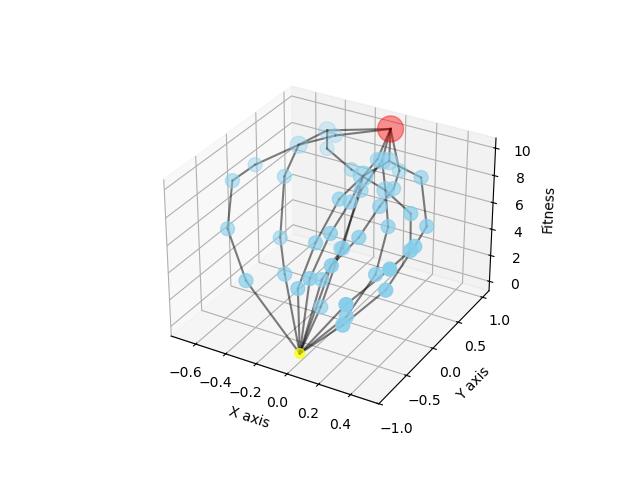

Run 1: Number of edges = 7
Run 2: Number of edges = 7
Run 3: Number of edges = 6
Run 4: Number of edges = 6
Run 5: Number of edges = 8
Run 6: Number of edges = 6
Run 7: Number of edges = 5
Run 8: Number of edges = 5
Run 9: Number of edges = 7
Run 10: Number of edges = 6
Nodes: 47
Edges: 58
Ends: 1
Avg. path length: 6.30 (std: 0.90)


In [131]:
plot_trajectory_network_3D(all_run_trajectories, show_labels=False, start_node_color='yellow', end_node_color='grey', best_node_color='red')

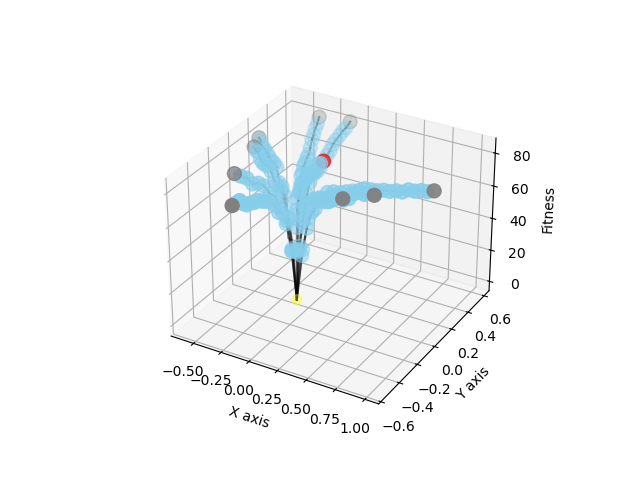

Run 1: Number of edges = 22
Run 2: Number of edges = 15
Run 3: Number of edges = 16
Run 4: Number of edges = 14
Run 5: Number of edges = 17
Run 6: Number of edges = 11
Run 7: Number of edges = 15
Run 8: Number of edges = 16
Run 9: Number of edges = 16
Run 10: Number of edges = 14
Nodes: 157
Edges: 156
Ends: 10
Avg. path length: 15.60 (std: 2.65)


In [ ]:
n_items = 100
ss = generate_zero_solution(n_items)
all_run_trajectories = run_multiple_ea_runs(num_runs=10, NGEN=100, popsize=100, tournsize=30, MUTPB=1, indpb=0.2, starting_solution=ss)
plot_trajectory_network_3D(all_run_trajectories, show_labels=False, start_node_color='yellow', end_node_color='grey', best_node_color='red')

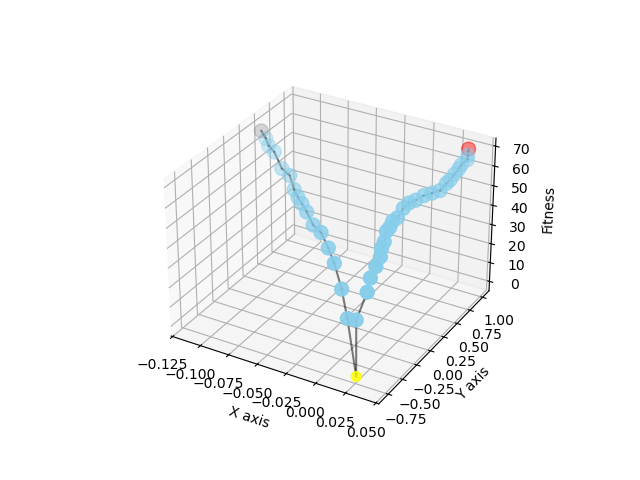

Run 1: Number of edges = 16
Run 2: Number of edges = 25
Nodes: 42
Edges: 41
Ends: 2
Avg. path length: 20.50 (std: 4.50)


In [139]:
n_items = 75
ss = generate_zero_solution(n_items)
all_run_trajectories = run_multiple_ea_runs(num_runs=2, NGEN=1000, popsize=100, tournsize=30, MUTPB=1, indpb=0.2, starting_solution=ss)
plot_trajectory_network_3D(all_run_trajectories, show_labels=False, start_node_color='yellow', end_node_color='grey', best_node_color='red')

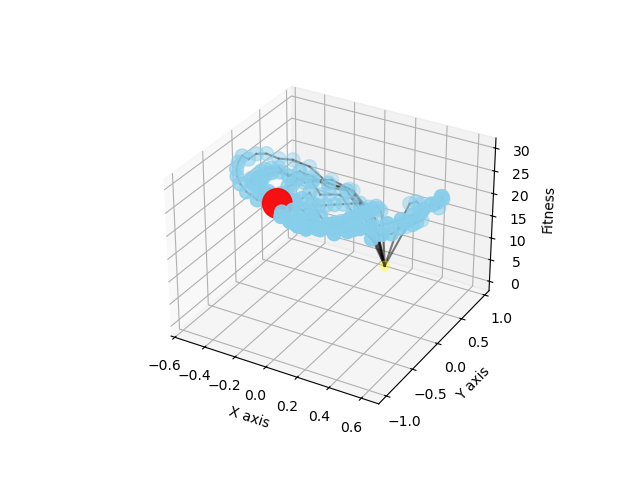

Run 1: Number of edges = 18
Run 2: Number of edges = 15
Run 3: Number of edges = 15
Run 4: Number of edges = 14
Run 5: Number of edges = 21
Run 6: Number of edges = 19
Run 7: Number of edges = 21
Run 8: Number of edges = 15
Run 9: Number of edges = 14
Run 10: Number of edges = 18
Nodes: 153
Edges: 168
Ends: 1
Avg. path length: 17.00 (std: 2.61)


In [152]:
n_items = 30
ss = generate_zero_solution(n_items)
all_run_trajectories = run_multiple_ea_runs(num_runs=10, NGEN=1000, popsize=10, tournsize=3, MUTPB=1, indpb=0.2, starting_solution=ss)
plot_trajectory_network_3D(all_run_trajectories, show_labels=False, start_node_color='yellow', end_node_color='grey', best_node_color='red')

In [151]:
# unique_solutions, unique_fitnesses, solution_iterations, transitions = all_run_trajectories
print(all_run_trajectories[0][0])

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0], [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1], [1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1], [0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0], [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1], [1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,

In [178]:
def umda_update_full(population, pop_size, select_size, replace_size, toolbox):
    # select from population
    selected_population = tools.selBest(population, select_size)

    # Calculate marginal propabilities
    probabilities = np.mean(selected_population, axis=0)

    new_solutions = []
    for _ in range(pop_size):
        new_solution = np.random.rand(n_items) < probabilities
        new_solution = creator.Individual(new_solution.astype(int).tolist())  # Create as DEAP Individual
        new_solutions.append(new_solution)
    
    return new_solutions

def UMDA(probsize, NGEN, popsize, selectsize, starting_solution=None):
    if not hasattr(creator, "OneMax_fitness"):
        creator.create("OneMax_fitness", base.Fitness, weights=(1.0,))
    if not hasattr(creator, "Individual"):
        creator.create("Individual", list, fitness=creator.OneMax_fitness)

    # Define the toolbox
    toolbox = base.Toolbox()
    toolbox.register("attr_bool", random.randint, 0, 1)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=probsize)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", lambda ind: (sum(ind),))

    # Create an initial population
    population = toolbox.population(n=popsize)

    # Set starting solution if provided
    if starting_solution is not None:
        for ind in population:
            ind[:] = starting_solution[:]

    # Recording every generation's population
    all_generations = []
    best_solutions = []
    best_fitnesses = []

    # Evaluate the initial population
    fitnesses = list(map(toolbox.evaluate, population))
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit

    # Record initial population and best solution
    all_generations.append([ind[:] for ind in population])
    best_individual = max(population, key=lambda ind: ind.fitness.values)
    best_solutions.append(toolbox.clone(best_individual))
    best_fitnesses.append(best_individual.fitness.values[0])

    # Evolutionary loop
    for gen in range(NGEN):
        population = umda_update_full(population, popsize, selectsize, 0, toolbox)

        fitnesses = list(map(toolbox.evaluate, population))
        for ind, fit in zip(population, fitnesses):
            ind.fitness.values = fit

        # Record current population and best solution
        all_generations.append([ind[:] for ind in population])
        best_individual = max(population, key=lambda ind: ind.fitness.values)
        best_solutions.append(toolbox.clone(best_individual))
        best_fitnesses.append(best_individual.fitness.values[0])

    return all_generations, best_solutions, best_fitnesses

def run_multiple_UMDA_runs(num_runs, probsize, NGEN, popsize, selectsize, starting_solution=None):
    all_run_trajectories = []
    for run in range(num_runs):
        _, best_solutions, best_fitnesses = UMDA(probsize, NGEN, popsize, selectsize, starting_solution)
        unique_solutions, unique_fitnesses, solution_iterations = extract_trajectory_data(best_solutions, best_fitnesses)
        transitions = extract_transitions(unique_solutions)
        all_run_trajectories.append((unique_solutions, unique_fitnesses, solution_iterations, transitions))
    return all_run_trajectories

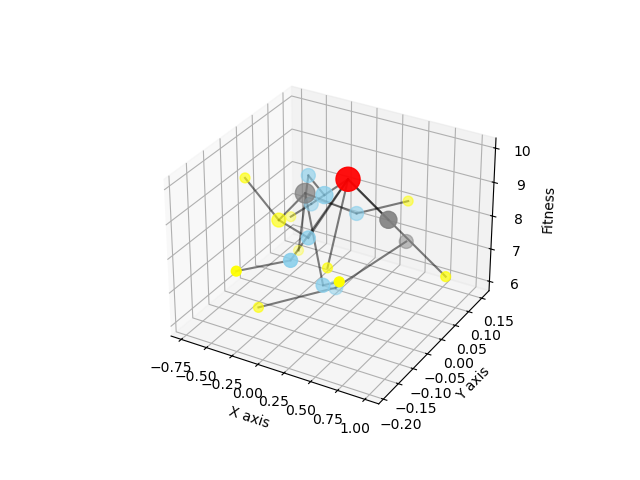

Run 1: Number of edges = 2
Run 2: Number of edges = 2
Run 3: Number of edges = 2
Run 4: Number of edges = 2
Run 5: Number of edges = 3
Run 6: Number of edges = 2
Run 7: Number of edges = 2
Run 8: Number of edges = 3
Run 9: Number of edges = 2
Run 10: Number of edges = 2
Nodes: 22
Edges: 21
Ends: 4
Avg. path length: 2.20 (std: 0.40)


In [ ]:
n_items = 10
ss = generate_zero_solution(n_items)
all_run_trajectories = run_multiple_UMDA_runs(num_runs=10, probsize=n_items, NGEN=10000, popsize=10, selectsize=5, starting_solution=None)
plot_trajectory_network_3D(all_run_trajectories, show_labels=False, start_node_color='yellow', end_node_color='grey', best_node_color='red')

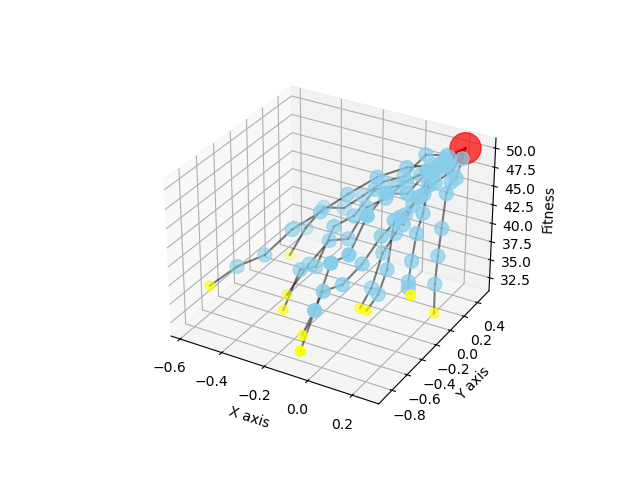

Run 1: Number of edges = 9
Run 2: Number of edges = 9
Run 3: Number of edges = 9
Run 4: Number of edges = 8
Run 5: Number of edges = 9
Run 6: Number of edges = 9
Run 7: Number of edges = 9
Run 8: Number of edges = 9
Run 9: Number of edges = 9
Run 10: Number of edges = 10
Nodes: 89
Edges: 89
Ends: 1
Avg. path length: 9.00 (std: 0.45)


No such comm: 564dc4bee9a745ab83ccdf20a84758c9
No such comm: 564dc4bee9a745ab83ccdf20a84758c9
No such comm: 564dc4bee9a745ab83ccdf20a84758c9
No such comm: 564dc4bee9a745ab83ccdf20a84758c9
No such comm: 564dc4bee9a745ab83ccdf20a84758c9
No such comm: 564dc4bee9a745ab83ccdf20a84758c9
No such comm: 564dc4bee9a745ab83ccdf20a84758c9
No such comm: 564dc4bee9a745ab83ccdf20a84758c9
No such comm: 564dc4bee9a745ab83ccdf20a84758c9
No such comm: 564dc4bee9a745ab83ccdf20a84758c9
No such comm: 564dc4bee9a745ab83ccdf20a84758c9
No such comm: 564dc4bee9a745ab83ccdf20a84758c9
No such comm: 564dc4bee9a745ab83ccdf20a84758c9
No such comm: 564dc4bee9a745ab83ccdf20a84758c9
No such comm: 564dc4bee9a745ab83ccdf20a84758c9
No such comm: 564dc4bee9a745ab83ccdf20a84758c9
No such comm: 564dc4bee9a745ab83ccdf20a84758c9
No such comm: 564dc4bee9a745ab83ccdf20a84758c9
No such comm: 564dc4bee9a745ab83ccdf20a84758c9
No such comm: 564dc4bee9a745ab83ccdf20a84758c9
No such comm: 564dc4bee9a745ab83ccdf20a84758c9
No such comm:

In [184]:
n_items = 50
ss = generate_zero_solution(n_items)
all_run_trajectories = run_multiple_UMDA_runs(num_runs=10, probsize=n_items, NGEN=1000, popsize=100, selectsize=50, starting_solution=None)
plot_trajectory_network_3D(all_run_trajectories, show_labels=False, start_node_color='yellow', end_node_color='grey', best_node_color='red')

In [187]:
n_items = 10
ss = generate_zero_solution(n_items)
all_run_trajectories1 = run_multiple_ea_runs(num_runs=5, NGEN=1000, popsize=10, tournsize=3, MUTPB=1, indpb=0.2, starting_solution=ss)
all_run_trajectories2 = run_multiple_ea_runs(num_runs=5, NGEN=1000, popsize=10, tournsize=3, MUTPB=1, indpb=0.2, starting_solution=ss)
# all_run_trajectories2 = run_multiple_UMDA_runs(num_runs=5, probsize=n_items, NGEN=1000, popsize=100, selectsize=50, starting_solution=None)

In [200]:
def plot_trajectory_network_dual(all_run_trajectories_1, all_run_trajectories_2, show_labels=False):
    import networkx as nx
    import matplotlib.pyplot as plt

    # Close any existing plots
    plt.close('all')

    G = nx.DiGraph()

    # Colors for the two sets of trajectories
    edge_color_1 = 'blue'
    edge_color_2 = 'orange'
    node_color_shared = 'green'

    # Add nodes and edges for each set of trajectories
    node_mapping = {}  # To ensure unique solutions map to the same node
    start_nodes = set()
    end_nodes = set()
    overall_best_node = None

    # Function to add nodes and edges to the graph
    def add_trajectories_to_graph(all_run_trajectories, edge_color):
        for run_idx, (unique_solutions, unique_fitnesses, _, transitions) in enumerate(all_run_trajectories):
            for i, solution in enumerate(unique_solutions):
                solution_tuple = tuple(solution)
                if solution_tuple not in node_mapping:
                    node_label = f"Solution {len(node_mapping) + 1}"
                    node_mapping[solution_tuple] = node_label
                    G.add_node(node_label, solution=solution, fitness=unique_fitnesses[i], run_idx=run_idx, step=i)
                else:
                    node_label = node_mapping[solution_tuple]

                # Set start and end nodes for coloring later
                if i == 0:
                    start_nodes.add(node_label)
                if i == len(unique_solutions) - 1:
                    end_nodes.add(node_label)

            # Add edges based on transitions
            for prev_solution, current_solution in transitions:
                if prev_solution in node_mapping and current_solution in node_mapping:
                    G.add_edge(node_mapping[prev_solution], node_mapping[current_solution], color=edge_color)

    # Add both sets of trajectories to the graph
    add_trajectories_to_graph(all_run_trajectories_1, edge_color_1)
    add_trajectories_to_graph(all_run_trajectories_2, edge_color_2)

    # Find the overall best solution across both sets of trajectories
    overall_best_fitness = max(
        max(best_fitnesses) for _, best_fitnesses, _, _ in (all_run_trajectories_1 + all_run_trajectories_2)
    )
    for node, data in G.nodes(data=True):
        if data['fitness'] == overall_best_fitness:
            overall_best_node = node
            break

    # Prepare node colors
    node_colors = []
    for node in G.nodes():
        if node == overall_best_node:
            node_colors.append('red')
        elif node in start_nodes:
            node_colors.append('yellow')
        elif node in end_nodes:
            node_colors.append('grey')
        else:
            # Check if the node exists in both sets of trajectories
            solution_tuple = next(key for key, value in node_mapping.items() if value == node)
            count_in_sets = 0
            for all_run_trajectories in [all_run_trajectories_1, all_run_trajectories_2]:
                for unique_solutions, _, _, _ in all_run_trajectories:
                    if solution_tuple in set(tuple(sol) for sol in unique_solutions):
                        count_in_sets += 1
            if count_in_sets > 1:
                node_colors.append(node_color_shared)
            else:
                node_colors.append('skyblue')

    # Draw the graph
    pos = nx.kamada_kawai_layout(G)
    node_sizes = [50 + G.in_degree(node) * 200 for node in G.nodes()]  # Base size of 50, increase by 200 per incoming edge
    edge_colors = [data['color'] for _, _, data in G.edges(data=True)]

    nx.draw(G, pos, with_labels=show_labels, node_size=node_sizes, node_color=node_colors, edge_color=edge_colors, font_size=8, font_weight="bold")
    if show_labels:
        node_labels = {node: f"{data['fitness']}" for node, data in G.nodes(data=True)}
        nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)
    plt.title("Trajectory Network comparison")
    plt.show()

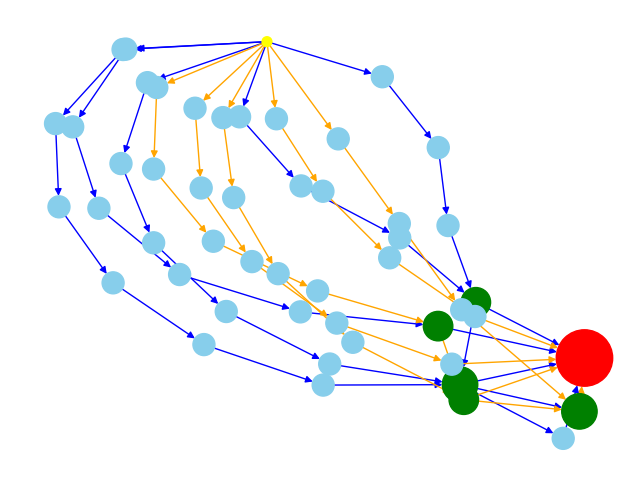

In [201]:
plot_trajectory_network_dual(all_run_trajectories1, all_run_trajectories2, show_labels=False)